In [1]:
"""Plots the loss of the model & performs basic evaluation - roughness dataset.
"""

'Plots the loss of the model & performs basic evaluation - roughness dataset.\n'

In [2]:
import pathlib
import torch
from typing import List, Union, Tuple
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.special import inv_boxcox
import pandas as pd
from dataset import RegressionDataset
from model import MLPRegRoughness

In [3]:
def plot_loss(
    model_name: str, train_loss: List[float], valid_loss: List[float]
) -> None:
    """Visualizes the loss data of the trained model.

    Args:
        model_name: Name of the trained model.
        train_loss: Loss data generated during training.
        valid_loss: Loss data generated during validation.
    """
    plt.figure(figsize=(12, 7))
    plt.suptitle(model_name + " loss values")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(train_loss)
    plt.plot(valid_loss)
    plt.legend(["Training Loss", "Validation Loss"])
    plt.show()

In [4]:
def txt_to_list(input_path: Union[pathlib.Path, str]) -> List[str]:
    """Loads a .txt file into a list.
    Args:
        input_path: Input path to the txt file.

    Returns:
        List containing data from the .txt file.
    """
    with open(input_path, "r") as f:
        data = f.read().splitlines()
    
    return data

In [5]:
model_name = 'lr_1_e_m4_b_8_e_8000_roughness_adapt_lr'

In [6]:
TRAINED_MODEL_PATH = f'./trained_models/{model_name}.pt'
TRAIN_LOSS_PATH = f'./trained_models/{model_name}_training_loss.txt'
VALID_LOSS_PATH = f'./trained_models/{model_name}_validation_loss.txt'

In [7]:
model_name = pathlib.Path(TRAINED_MODEL_PATH).stem
train_loss= txt_to_list(TRAIN_LOSS_PATH)
valid_loss= txt_to_list(VALID_LOSS_PATH)

In [8]:
# Convert str to float & tidy up.
train_loss = [float(el) for el in train_loss]
train_loss = [round(el, 4) for el in train_loss]

valid_loss = [float(el) for el in valid_loss]
valid_loss = [round(el, 4) for el in valid_loss]

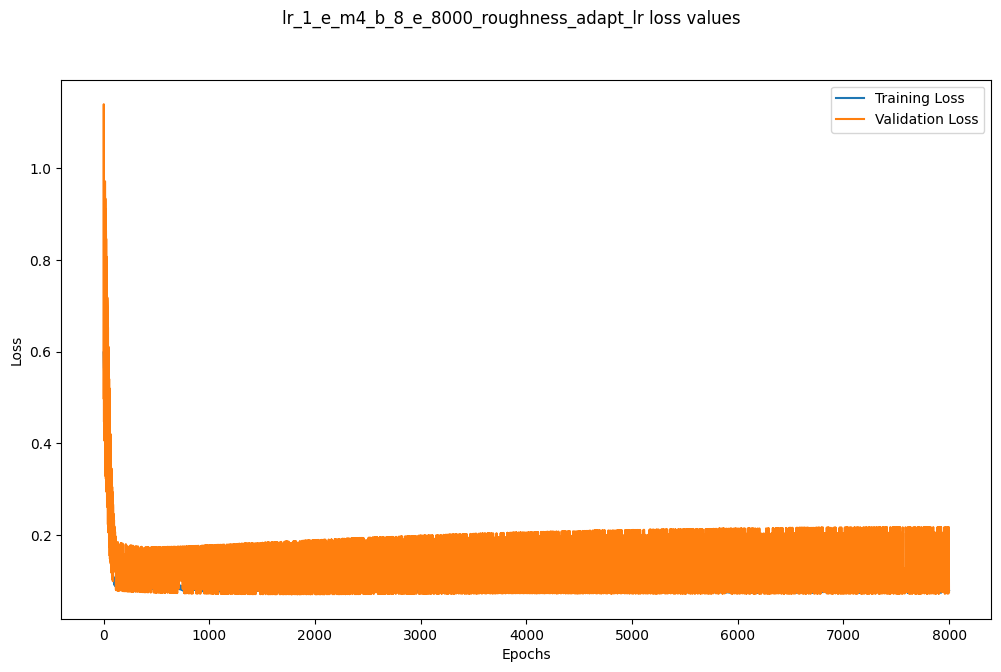

In [9]:
plot_loss(model_name, train_loss, valid_loss)

In [10]:
TRAINED_STATE_DICT_PATH = f'./trained_models/{model_name}_state_dict'

In [11]:
# Set the device & clean the memory.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
torch.cuda.empty_cache()

Device:  cuda:0


In [12]:
# Load the trained model state dictionary.
model = MLPRegRoughness()
model.load_state_dict(torch.load(TRAINED_STATE_DICT_PATH))

/tmp/ipykernel_407935/3511706311.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(TRAINED_STATE_DICT_PATH))


<All keys matched successfully>

In [13]:
# Load test dataset.
batch_size = 8
dataset_path = "./data/dataset_roughness_test.csv"
features = ["Ra", "Rz", "RSm", "Rt"]
labels = ["F"]

test_dataset = RegressionDataset(dataset_path, features, labels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [14]:
# Pre - normalization min and max values of output variables. 
f_min = 69.33787637
f_max = 384.2596778

In [15]:
# Evaluate the model.
f_preds = []
f_actuals = []
for batch_features, batch_labels in test_dataloader:
    outputs = model(batch_features)
    predicted_labels = outputs.detach().numpy()

    for i in range(len(batch_features)):
        features = batch_features[i]
        labels = batch_labels[i]
        predicted = predicted_labels[i]
      
        f_pred = predicted[0]
        f_actual = labels.numpy()[0]

        f_preds.append(f_pred)
        f_actuals.append(f_actual)

In [16]:
f_preds = np.array(f_preds)
f_actuals = np.array(f_actuals)

In [17]:
# Scale the predictions and ground truth labels back to nominal range.
f_preds = f_preds * (f_max - f_min) + f_min
f_actuals = f_actuals * (f_max - f_min) + f_min

In [18]:
generalization_errors = []

for i in range(len(f_preds)):

        f_pred = f_preds[i]
        f_actual = f_actuals[i]
    
        print("Predicted F:,", f_pred)
        print("Actual F:,", f_actual)

        generalization_error = round(abs(f_pred - f_actual), 4)
        print('Error:', generalization_error)
        generalization_errors.append(generalization_error)

        print("------------------")

Predicted F:, 194.80606
Actual F:, 356.7561
Error: 161.95
------------------
Predicted F:, 198.97975
Actual F:, 209.42088
Error: 10.4411
------------------
Predicted F:, 183.41678
Actual F:, 157.35754
Error: 26.0592
------------------
Predicted F:, 193.57321
Actual F:, 236.02104
Error: 42.4478
------------------
Predicted F:, 184.94688
Actual F:, 116.4756
Error: 68.4713
------------------
Predicted F:, 192.29572
Actual F:, 211.95287
Error: 19.6572
------------------
Predicted F:, 186.5828
Actual F:, 69.600494
Error: 116.9823
------------------
Predicted F:, 179.17184
Actual F:, 108.23137
Error: 70.9405
------------------
Predicted F:, 191.98755
Actual F:, 205.16371
Error: 13.1762
------------------
Predicted F:, 190.21112
Actual F:, 73.83536
Error: 116.3758
------------------


In [19]:
generalization_errors = np.array(generalization_errors)
mae = np.sum(generalization_errors / np.shape(generalization_errors)[0])

In [20]:
print('MAE:', np.round(mae, 4))

MAE: 64.6501
